In [14]:
import pandas as pd
from sqlalchemy import create_engine

# database_url = "sqlite:////content/data.sqlite"
database_url = "sqlite:///../data/data.sqlite"
engine = create_engine(database_url)

# 从数据库读取数据
query = "select date as ds, global_entry, hkmo_entry, tw_entry from sh_visitors_daily"
df = pd.read_sql_query(query, engine, index_col='ds', parse_dates=['ds'])

In [15]:
# for plotting, run: pip install pandas matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from chronos import ChronosPipeline

pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-base",
    device_map="cuda" if torch.cuda.is_available() else "cpu",
    # use "cpu" for CPU inference and "mps" for Apple Silicon
    torch_dtype=torch.float,
)

test, validate = df['hkmo_entry'][:-60], df['hkmo_entry'][-60:]

# context must be either a 1D tensor, a list of 1D tensors,
# or a left-padded 2D tensor with batch as the first dimension
context = torch.tensor(test)
prediction_length = 60
forecast = pipeline.predict(
    context,
    prediction_length,
    num_samples=1,
    temperature=1.0,
    top_k=50,
    top_p=1.0,
)  # forecast shape: [num_series, num_samples, prediction_length]

/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/var/folders/wb/86d7j5hx6lz71vnrk3q5ksmr0000gn/T/ipykernel_82060/3510626448.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  context = torch.tensor(test)


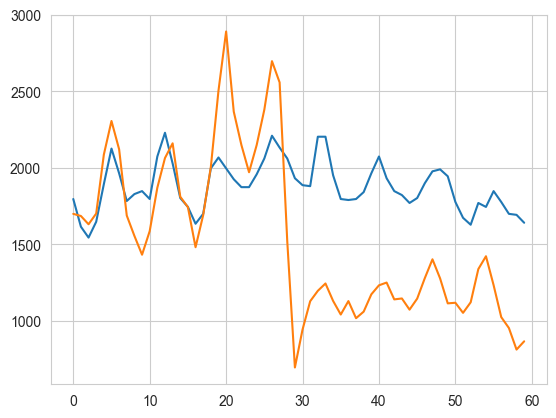

In [23]:
pred = forecast[0].numpy().T
plt.plot(pred)
plt.plot(validate.values)

In [21]:
from neuralforecast.losses.numpy import mae, rmse, mape

mae1 = mae(validate.values, pred)
rmse1 = rmse(validate.values, pred)
smape1 = mape(validate.values, pred)

mae1, rmse1, smape1

(557.2670283338758, 641.4691273445711, 0.4500303339406609)